## Занятие 7. Модели диффузии
___
#### Случайные блуждания и движения броуновской частицы

Впервые случайное движение частиц (пыльцевых зерен) в воде наблюдал Роберт Броун в 1827 году. Это движение было названо броуновским. Впоследствии данное явление было объяснено Эйнштейном теоретически в 1905 году, который показал, что среднеквадратичное смещение броуновской частицы  
\begin{equation}
<r^2(t)> \sim t  \tag{1}
\end{equation}
Броуновское движение, описываемое уравнением (1), может быть промодулировано с помощью метода случайных блужданий, в котором броуновская частица смещается в единицу времени на единичное расстояние в случайном направлении.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

In [42]:
class Walker:
    
    def __init__(self, N, steps):
        self.N = N
        self.steps = steps
        self.sh = np.zeros((self.steps, 2))
        
    def nbrs(self, x, y):
        return [(x + i, y) for i in [-1, 1] if 0 <= x + i < self.N] + [(x, y + j) for j in [-1, 1] if 0 <= y + j < self.N]
    
    
    def get_rt(self):
        self.rt = np.zeros(self.steps)
        for i in range(self.steps):
            self.rt[i] = np.linalg.norm(self.sh[0] - self.sh[i])
        return self.rt
    
    def run(self, position):
        self.sh[0] = position
        
        for step in range(1, self.steps):
            pos_positions = self.nbrs(*self.sh[step-1])
            index = np.random.randint(low=0, high=len(pos_positions))
            new_position = pos_positions[index]
            self.sh[step] = new_position
            
    def show_walks(self, lim=None):
        if lim is None:
            lim = self.steps
        plt.figure(figsize=(8,8))
        
        plt.xlim(0, self.N)
        plt.ylim(0, self.N)
        
        plt.grid()
        plt.plot(self.sh[:lim, 0], self.sh[:lim, 1], marker='o', lw=2, zorder=0)
        plt.scatter(self.sh[0,0], self.sh[0,1], s=200, c='red')
        plt.scatter(self.sh[lim-1,0], self.sh[lim-1,1], s=200, c='limegreen')

In [43]:
w = Walker(10, 20)

w.run((5, 5))

In [53]:
N = 40 
steps = 200
runs = 60
rts = np.zeros((runs, steps))
for i in range(runs):
    w = Walker(N, steps)

    w.run(np.random.randint(0, N, size=2))
    rts[i] = w.get_rt()
    

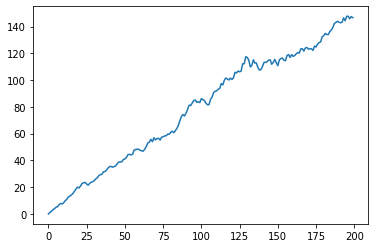

In [54]:
plt.plot(np.mean(rts**2, axis=0))

#### Классификация типов диффузионного движения 
В реальных системах часто наблюдается ситуации, когда закон (1) нарушается и между средним квадратом смещения и временем реализуется нелинейная зависимость
\begin{equation}
    <r^2(t)> \sim t^\gamma, 
    где \hspace{0.1cm} 0 < \gamma \leq 2
\end{equation}

|Диапозон $\gamma$ &nbsp; &nbsp;|Diffusion Type|
| ----- | --- |
|$\gamma = 1$ | Обычная (нормальная)|
|$1 < \gamma \leq 2$ | Быстрая (аномальная)|
|$0 \leq \gamma < 1$ | Медленная (аномальная)|

В некоторых случаях наблюдается также ультрамедленная диффузия 
$$<r^2(t)> \sim (\ln t)^\alpha, \alpha > 0$$

Аномальная диффузия обычно наблюдается для систем, в которых существет определенная корреляция. Нормальная диффузия предполагает полную статистическую независимость последовательных случайных блужданий при условии не очень широкого распределения для длин и времени.


#### Пример аномальной диффузии. Модель "прыжков Леви"
В рамках данной модели длина шага $h$ не является постоянной величиной и может изменяться с определенной вероятностью $f(h)$, принимая целые значения из промежутка $h \in [1, \infty]$:

$$f(h) = c \cdot h^{-\mu}$$

где $1 \leq \mu < \infty $, a $c = 6 / \pi^2$ при  $\mu = 2$.

$\sum f(h) = 1$

In [55]:
distribution = lambda x: 6 / (np.pi *x) ** 2

In [59]:
x = np.arange(1, 12)

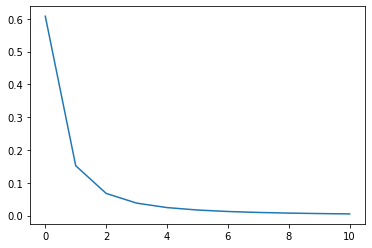

In [60]:
plt.plot(distribution(x))

In [61]:
def generate_random_number(func, x1, x2, y1=0, y2=1):
    y = 1
    point = 0
    
    while y > point:
        x = np.random.randint(x1, x2)
        y = (y2 - y1) * np.random.rand() + y1
        point = func(x)
    return x
    

In [62]:
test = [generate_random_number(distribution, 1, 12) for _ in range(10000)]

(array([0.6479, 0.1539, 0.0725, 0.0386, 0.0259, 0.019 , 0.0125, 0.0102,
        0.0078, 0.0117]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

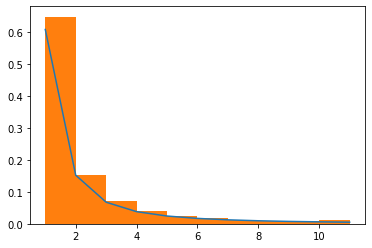

In [65]:
plt.plot(x, distribution(x))
plt.hist(test, density=True)

In [66]:
class LevyJumps(Walker):
    
    def generate_random_number(self, func, x1, x2, y1=0, y2=1):
        y = 1
        point = 0

        while y > point:
            x = np.random.randint(x1, x2)
            y = (y2 - y1) * np.random.rand() + y1
            point = func(x)
        return x
    
    def nbrs(self, x, y, x_shift, y_shift):
        pos_positions = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                point = x + i * x_shift, y + j * y_shift
                if 0 <= point[0] < self.N and 0 <= point[1] < self.N:
                    pos_positions.append(point)
        return pos_positions
    
    def get_new_position(self, prev_position, func, x1, x2, y1, y2):
        x, y = prev_position
        new_position = None
        
        while True:
            x_shift = self.generate_random_number(func, x1, x2, y1, y2)
            y_shift = self.generate_random_number(func, x1, x2, y1, y2)
            
            if pos_positions := self.nbrs(x, y, x_shift, y_shift):
                index = np.random.randint(0, len(pos_positions))
                new_position = pos_positions[index]
                break
        
        return new_position
    
    def run(self, position, func, x1, x2, y1=0, y2=1):
        self.sh[0] = position
        for step in range(1, self.steps):
            new_postion = self.get_new_position(self.sh[step-1], func, x1, x2, y1, y2)
            self.sh[step] = new_postion

In [67]:
w = LevyJumps(20, 200)

In [68]:
w.run((10, 10), distribution, 1, 12)

In [69]:
interact(w.show_walks, lim=(0, w.steps))

interactive(children=(IntSlider(value=100, description='lim', max=200), Output()), _dom_classes=('widget-inter…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [73]:
N = 40 
steps = 200
runs = 40
rts = np.zeros((runs, steps))
for i in range(runs):
    w = LevyJumps(N, steps)

    w.run(np.random.randint(0, N, size=2), distribution, 1, 12)
    rts[i] = w.get_rt()

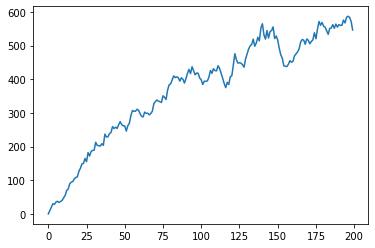

In [74]:
plt.plot(np.mean(rts**2, axis=0))